In [1]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <https://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <https://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Vietnamese.txt', 'data/names/English.txt', 'data/names/Greek.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Portuguese.txt', 'data/names/French.txt', 'data/names/Polish.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Scottish.txt', 'data/names/Czech.txt', 'data/names/Korean.txt', 'data/names/Irish.txt', 'data/names/Dutch.txt', 'data/names/Italian.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [6]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8381, -2.8680, -2.8855, -2.8519, -2.9776, -2.9139, -2.8626, -2.8824,
         -2.9422, -2.8815, -2.9105, -2.8987, -2.9380, -2.8558, -2.9255, -2.8284,
         -2.8899, -2.8890]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 15)


We will also want a quick way to get a training example (a name and its
language):




In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Zouvelekis
category = Scottish / line = Fraser
category = Spanish / line = Bonaventura
category = Italian / line = Guerra
category = Arabic / line = Baz
category = Vietnamese / line = Pham
category = Scottish / line = Bell
category = Korean / line = Bang
category = Arabic / line = Dagher
category = English / line = Graham


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [10]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [11]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.6290 Taidhg / Scottish ✗ (Irish)
10000 10% (0m 10s) 1.3198 Ahn / Chinese ✗ (Korean)
15000 15% (0m 15s) 1.2427 Chu / Vietnamese ✓
20000 20% (0m 20s) 1.3755 Niall / Irish ✓
25000 25% (0m 25s) 1.1860 Bermudez / Spanish ✓
30000 30% (0m 30s) 0.6247 Hui / Chinese ✓
35000 35% (0m 35s) 0.2748 Paraskevopoulos / Greek ✓
40000 40% (0m 40s) 2.7808 Salazar / Czech ✗ (Portuguese)
45000 45% (0m 45s) 1.8425 Abreu / Portuguese ✗ (Spanish)
50000 50% (0m 50s) 3.9618 Salomon / French ✗ (Polish)
55000 55% (0m 55s) 0.8203 Yankovsky / Russian ✓
60000 60% (1m 0s) 0.2504 Dubhain / Irish ✓
65000 65% (1m 5s) 0.2495 Amari / Arabic ✓
70000 70% (1m 10s) 2.3648 Mata / Japanese ✗ (Portuguese)
75000 75% (1m 15s) 0.9412 Slezak / Polish ✗ (Czech)
80000 80% (1m 20s) 3.3171 Laar / Arabic ✗ (Dutch)
85000 85% (1m 25s) 0.0284 Vuong / Vietnamese ✓
90000 90% (1m 30s) 4.2459 Salomon / Dutch ✗ (Italian)
95000 95% (1m 35s) 6.7035 Kalimahi / Japanese ✗ (Russian)
100000 100% (1m 40s) 0.4194 Si / Korean ✓


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




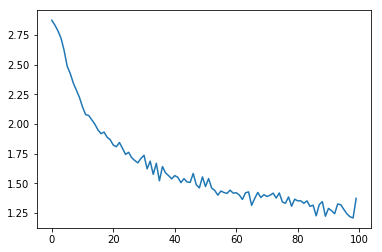

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




--- 0.0007615089416503906 seconds ---
--- 0.0006134510040283203 seconds ---
--- 0.0008671283721923828 seconds ---
--- 0.0006439685821533203 seconds ---
--- 0.0004248619079589844 seconds ---
--- 0.0007011890411376953 seconds ---
--- 0.0005557537078857422 seconds ---
--- 0.0006315708160400391 seconds ---
--- 0.0007040500640869141 seconds ---
--- 0.0003993511199951172 seconds ---
--- 0.0004794597625732422 seconds ---
--- 0.00040912628173828125 seconds ---
--- 0.0007014274597167969 seconds ---
--- 0.00039839744567871094 seconds ---
--- 0.0005261898040771484 seconds ---
--- 0.0006132125854492188 seconds ---
--- 0.0004458427429199219 seconds ---
--- 0.0005292892456054688 seconds ---
--- 0.0005927085876464844 seconds ---
--- 0.0003402233123779297 seconds ---
--- 0.0004010200500488281 seconds ---
--- 0.0004737377166748047 seconds ---
--- 0.00027370452880859375 seconds ---
--- 0.00039958953857421875 seconds ---
--- 0.00033855438232421875 seconds ---
--- 0.0005292892456054688 seconds ---
--- 0.0

--- 0.0017724037170410156 seconds ---
--- 0.00034499168395996094 seconds ---
--- 0.0004544258117675781 seconds ---
--- 0.0005028247833251953 seconds ---
--- 0.0002238750457763672 seconds ---
--- 0.0008189678192138672 seconds ---
--- 0.0007710456848144531 seconds ---
--- 0.0005209445953369141 seconds ---
--- 0.0007014274597167969 seconds ---
--- 0.0005090236663818359 seconds ---
--- 0.00038552284240722656 seconds ---
--- 0.0005943775177001953 seconds ---
--- 0.0003256797790527344 seconds ---
--- 0.0004067420959472656 seconds ---
--- 0.00014972686767578125 seconds ---
--- 0.0007381439208984375 seconds ---
--- 0.00032329559326171875 seconds ---
--- 0.0004799365997314453 seconds ---
--- 0.0004639625549316406 seconds ---
--- 0.00044918060302734375 seconds ---
--- 0.0005791187286376953 seconds ---
--- 0.0004966259002685547 seconds ---
--- 0.0005371570587158203 seconds ---
--- 0.0002789497375488281 seconds ---
--- 0.00040221214294433594 seconds ---
--- 0.0004725456237792969 seconds ---
--- 0.

--- 0.002295970916748047 seconds ---
--- 0.0004944801330566406 seconds ---
--- 0.0003457069396972656 seconds ---
--- 0.0002167224884033203 seconds ---
--- 0.00021696090698242188 seconds ---
--- 0.0005662441253662109 seconds ---
--- 0.0003447532653808594 seconds ---
--- 0.0003447532653808594 seconds ---
--- 0.0004725456237792969 seconds ---
--- 0.00041031837463378906 seconds ---
--- 0.00040602684020996094 seconds ---
--- 0.0001494884490966797 seconds ---
--- 0.0005328655242919922 seconds ---
--- 0.0004756450653076172 seconds ---
--- 0.0002148151397705078 seconds ---
--- 0.0002796649932861328 seconds ---
--- 0.0006341934204101562 seconds ---
--- 0.0003459453582763672 seconds ---
--- 0.00027680397033691406 seconds ---
--- 0.0004703998565673828 seconds ---
--- 0.0004813671112060547 seconds ---
--- 0.0007293224334716797 seconds ---
--- 0.00047087669372558594 seconds ---
--- 0.0004062652587890625 seconds ---
--- 0.0007257461547851562 seconds ---
--- 0.00047278404235839844 seconds ---
--- 0.0

--- 0.0006127357482910156 seconds ---
--- 0.0006854534149169922 seconds ---
--- 0.0005319118499755859 seconds ---
--- 0.00034308433532714844 seconds ---
--- 0.0003635883331298828 seconds ---
--- 0.0004601478576660156 seconds ---
--- 0.00021409988403320312 seconds ---
--- 0.0004723072052001953 seconds ---
--- 0.0002777576446533203 seconds ---
--- 0.0009074211120605469 seconds ---
--- 0.0001533031463623047 seconds ---
--- 0.00034046173095703125 seconds ---
--- 0.0005145072937011719 seconds ---
--- 0.0007166862487792969 seconds ---
--- 0.00037789344787597656 seconds ---
--- 0.0005362033843994141 seconds ---
--- 0.0004715919494628906 seconds ---
--- 0.0007216930389404297 seconds ---
--- 0.0005335807800292969 seconds ---
--- 0.0005292892456054688 seconds ---
--- 0.0005397796630859375 seconds ---
--- 0.00033926963806152344 seconds ---
--- 0.0006561279296875 seconds ---
--- 0.0003399848937988281 seconds ---
--- 0.00040221214294433594 seconds ---
--- 0.0003383159637451172 seconds ---
--- 0.000

--- 0.0009081363677978516 seconds ---
--- 0.0005211830139160156 seconds ---
--- 0.0006110668182373047 seconds ---
--- 0.00046515464782714844 seconds ---
--- 0.0007064342498779297 seconds ---
--- 0.0004324913024902344 seconds ---
--- 0.0003407001495361328 seconds ---
--- 0.0005300045013427734 seconds ---
--- 0.000408172607421875 seconds ---
--- 0.0002751350402832031 seconds ---
--- 0.0003421306610107422 seconds ---
--- 0.0003387928009033203 seconds ---
--- 0.00040984153747558594 seconds ---
--- 0.00027751922607421875 seconds ---
--- 0.00021123886108398438 seconds ---
--- 0.0005786418914794922 seconds ---
--- 0.0004050731658935547 seconds ---
--- 0.00014710426330566406 seconds ---
--- 0.0006666183471679688 seconds ---
--- 0.000469207763671875 seconds ---
--- 0.00021338462829589844 seconds ---
--- 0.0006589889526367188 seconds ---
--- 0.0005311965942382812 seconds ---
--- 0.0004665851593017578 seconds ---
--- 0.0005307197570800781 seconds ---
--- 0.0004062652587890625 seconds ---
--- 0.00

--- 0.0006163120269775391 seconds ---
--- 0.0006060600280761719 seconds ---
--- 0.0005309581756591797 seconds ---
--- 0.00033855438232421875 seconds ---
--- 0.0004012584686279297 seconds ---
--- 0.00040268898010253906 seconds ---
--- 0.0004000663757324219 seconds ---
--- 0.0004658699035644531 seconds ---
--- 0.0005288124084472656 seconds ---
--- 0.0005280971527099609 seconds ---
--- 0.0004115104675292969 seconds ---
--- 0.0003383159637451172 seconds ---
--- 0.0003387928009033203 seconds ---
--- 0.0004017353057861328 seconds ---
--- 0.00033855438232421875 seconds ---
--- 0.0004017353057861328 seconds ---
--- 0.0005352497100830078 seconds ---
--- 0.00040602684020996094 seconds ---
--- 0.0004668235778808594 seconds ---
--- 0.00040030479431152344 seconds ---
--- 0.0006561279296875 seconds ---
--- 0.0004055500030517578 seconds ---
--- 0.0006563663482666016 seconds ---
--- 0.0002739429473876953 seconds ---
--- 0.0005857944488525391 seconds ---
--- 0.0003426074981689453 seconds ---
--- 0.0006

--- 0.0017366409301757812 seconds ---
--- 0.0005471706390380859 seconds ---
--- 0.00022220611572265625 seconds ---
--- 0.0006551742553710938 seconds ---
--- 0.00041031837463378906 seconds ---
--- 0.00047278404235839844 seconds ---
--- 0.00040841102600097656 seconds ---
--- 0.00033974647521972656 seconds ---
--- 0.0004057884216308594 seconds ---
--- 0.0005984306335449219 seconds ---
--- 0.0006062984466552734 seconds ---
--- 0.0006017684936523438 seconds ---
--- 0.0004146099090576172 seconds ---
--- 0.0002818107604980469 seconds ---
--- 0.0005998611450195312 seconds ---
--- 0.00040435791015625 seconds ---
--- 0.0005342960357666016 seconds ---
--- 0.0004711151123046875 seconds ---
--- 0.0003426074981689453 seconds ---
--- 0.0002124309539794922 seconds ---
--- 0.0003399848937988281 seconds ---
--- 0.0002777576446533203 seconds ---
--- 0.0005350112915039062 seconds ---
--- 0.0004096031188964844 seconds ---
--- 0.00021338462829589844 seconds ---
--- 0.000598907470703125 seconds ---
--- 0.000

--- 0.0005562305450439453 seconds ---
--- 0.0005853176116943359 seconds ---
--- 0.00048232078552246094 seconds ---
--- 0.0007886886596679688 seconds ---
--- 0.00054168701171875 seconds ---
--- 0.00040435791015625 seconds ---
--- 0.0003402233123779297 seconds ---
--- 0.00033926963806152344 seconds ---
--- 0.0005338191986083984 seconds ---
--- 0.0004711151123046875 seconds ---
--- 0.0003407001495361328 seconds ---
--- 0.00034117698669433594 seconds ---
--- 0.0002799034118652344 seconds ---
--- 0.0002124309539794922 seconds ---
--- 0.0005955696105957031 seconds ---
--- 0.00046944618225097656 seconds ---
--- 0.0004703998565673828 seconds ---
--- 0.00040602684020996094 seconds ---
--- 0.0006585121154785156 seconds ---
--- 0.00046896934509277344 seconds ---
--- 0.0002765655517578125 seconds ---
--- 0.0003399848937988281 seconds ---
--- 0.0004074573516845703 seconds ---
--- 0.0004684925079345703 seconds ---
--- 0.000274658203125 seconds ---
--- 0.0005950927734375 seconds ---
--- 0.00059509277

--- 0.0024089813232421875 seconds ---
--- 0.0007243156433105469 seconds ---
--- 0.00047469139099121094 seconds ---
--- 0.00047397613525390625 seconds ---
--- 0.0006010532379150391 seconds ---
--- 0.0006709098815917969 seconds ---
--- 0.0004074573516845703 seconds ---
--- 0.0002799034118652344 seconds ---
--- 0.0005974769592285156 seconds ---
--- 0.0002791881561279297 seconds ---
--- 0.00040721893310546875 seconds ---
--- 0.00027942657470703125 seconds ---
--- 0.0002143383026123047 seconds ---
--- 0.0006971359252929688 seconds ---
--- 0.0005388259887695312 seconds ---
--- 0.0005977153778076172 seconds ---
--- 0.0005459785461425781 seconds ---
--- 0.0002148151397705078 seconds ---
--- 0.000278472900390625 seconds ---
--- 0.00040602684020996094 seconds ---
--- 0.00027632713317871094 seconds ---
--- 0.0005350112915039062 seconds ---
--- 0.0006093978881835938 seconds ---
--- 0.00014925003051757812 seconds ---
--- 0.00021505355834960938 seconds ---
--- 0.0006265640258789062 seconds ---
--- 0

--- 0.0007212162017822266 seconds ---
--- 0.0008528232574462891 seconds ---
--- 0.0006773471832275391 seconds ---
--- 0.0006709098815917969 seconds ---
--- 0.00021910667419433594 seconds ---
--- 0.00033974647521972656 seconds ---
--- 0.0003814697265625 seconds ---
--- 0.0004642009735107422 seconds ---
--- 0.00021314620971679688 seconds ---
--- 0.0007834434509277344 seconds ---
--- 0.0002796649932861328 seconds ---
--- 0.0006518363952636719 seconds ---
--- 0.0004050731658935547 seconds ---
--- 0.0007171630859375 seconds ---
--- 0.00040459632873535156 seconds ---
--- 0.0003390312194824219 seconds ---
--- 0.0006549358367919922 seconds ---
--- 0.0005300045013427734 seconds ---
--- 0.0004031658172607422 seconds ---
--- 0.00034737586975097656 seconds ---
--- 0.0004627704620361328 seconds ---
--- 0.0005934238433837891 seconds ---
--- 0.00033664703369140625 seconds ---
--- 0.00021147727966308594 seconds ---
--- 0.0005292892456054688 seconds ---
--- 0.0003485679626464844 seconds ---
--- 0.00034

--- 0.00084686279296875 seconds ---
--- 0.0006463527679443359 seconds ---
--- 0.0006542205810546875 seconds ---
--- 0.0004699230194091797 seconds ---
--- 0.0002758502960205078 seconds ---
--- 0.0004010200500488281 seconds ---
--- 0.0004036426544189453 seconds ---
--- 0.0004115104675292969 seconds ---
--- 0.0004036426544189453 seconds ---
--- 0.00027632713317871094 seconds ---
--- 0.0005953311920166016 seconds ---
--- 0.00027632713317871094 seconds ---
--- 0.00040435791015625 seconds ---
--- 0.00054168701171875 seconds ---
--- 0.0007314682006835938 seconds ---
--- 0.0004703998565673828 seconds ---
--- 0.0004036426544189453 seconds ---
--- 0.0005331039428710938 seconds ---
--- 0.0005373954772949219 seconds ---
--- 0.000278472900390625 seconds ---
--- 0.0003407001495361328 seconds ---
--- 0.00040602684020996094 seconds ---
--- 0.0004050731658935547 seconds ---
--- 0.00047135353088378906 seconds ---
--- 0.000339508056640625 seconds ---
--- 0.00021195411682128906 seconds ---
--- 0.000466585

--- 0.001953601837158203 seconds ---
--- 0.0006458759307861328 seconds ---
--- 0.0007021427154541016 seconds ---
--- 0.0006737709045410156 seconds ---
--- 0.0006046295166015625 seconds ---
--- 0.0005645751953125 seconds ---
--- 0.0008366107940673828 seconds ---
--- 0.0008368492126464844 seconds ---
--- 0.0005066394805908203 seconds ---
--- 0.0006949901580810547 seconds ---
--- 0.00035262107849121094 seconds ---
--- 0.0007236003875732422 seconds ---
--- 0.00045871734619140625 seconds ---
--- 0.00036716461181640625 seconds ---
--- 0.0009171962738037109 seconds ---
--- 0.0003883838653564453 seconds ---
--- 0.0005962848663330078 seconds ---
--- 0.0002791881561279297 seconds ---
--- 0.0002129077911376953 seconds ---
--- 0.0004470348358154297 seconds ---
--- 0.0007500648498535156 seconds ---
--- 0.0006537437438964844 seconds ---
--- 0.0004968643188476562 seconds ---
--- 0.0003223419189453125 seconds ---
--- 0.0004177093505859375 seconds ---
--- 0.0006999969482421875 seconds ---
--- 0.0006673

--- 0.0003826618194580078 seconds ---
--- 0.0005559921264648438 seconds ---
--- 0.00040459632873535156 seconds ---
--- 0.0010747909545898438 seconds ---
--- 0.00028204917907714844 seconds ---
--- 0.00027871131896972656 seconds ---
--- 0.00021648406982421875 seconds ---
--- 0.0006687641143798828 seconds ---
--- 0.00067901611328125 seconds ---
--- 0.00047087669372558594 seconds ---
--- 0.0003421306610107422 seconds ---
--- 0.0006725788116455078 seconds ---
--- 0.00014972686767578125 seconds ---
--- 0.0006806850433349609 seconds ---
--- 0.0004105567932128906 seconds ---
--- 0.00046753883361816406 seconds ---
--- 0.00040793418884277344 seconds ---
--- 0.0004076957702636719 seconds ---
--- 0.0005981922149658203 seconds ---
--- 0.0004374980926513672 seconds ---
--- 0.00027871131896972656 seconds ---
--- 0.0004696846008300781 seconds ---
--- 0.00034546852111816406 seconds ---
--- 0.0006060600280761719 seconds ---
--- 0.0002791881561279297 seconds ---
--- 0.0005393028259277344 seconds ---
--- 

--- 0.0018765926361083984 seconds ---
--- 0.0009162425994873047 seconds ---
--- 0.0006656646728515625 seconds ---
--- 0.00043892860412597656 seconds ---
--- 0.0005810260772705078 seconds ---
--- 0.00039005279541015625 seconds ---
--- 0.0001499652862548828 seconds ---
--- 0.0005505084991455078 seconds ---
--- 0.0003914833068847656 seconds ---
--- 0.0003809928894042969 seconds ---
--- 0.0008227825164794922 seconds ---
--- 0.000598907470703125 seconds ---
--- 0.0006074905395507812 seconds ---
--- 0.0005948543548583984 seconds ---
--- 0.0005395412445068359 seconds ---
--- 0.0007033348083496094 seconds ---
--- 0.0004458427429199219 seconds ---
--- 0.00039577484130859375 seconds ---
--- 0.001056671142578125 seconds ---
--- 0.0008001327514648438 seconds ---
--- 0.0005540847778320312 seconds ---
--- 0.0007007122039794922 seconds ---
--- 0.0006589889526367188 seconds ---
--- 0.0007331371307373047 seconds ---
--- 0.00043845176696777344 seconds ---
--- 0.0008831024169921875 seconds ---
--- 0.0006

--- 0.0023865699768066406 seconds ---
--- 0.0007245540618896484 seconds ---
--- 0.000640869140625 seconds ---
--- 0.0004572868347167969 seconds ---
--- 0.0007154941558837891 seconds ---
--- 0.0006878376007080078 seconds ---
--- 0.00022721290588378906 seconds ---
--- 0.0007145404815673828 seconds ---
--- 0.0002548694610595703 seconds ---
--- 0.0007250308990478516 seconds ---
--- 0.0008175373077392578 seconds ---
--- 0.0006043910980224609 seconds ---
--- 0.0009706020355224609 seconds ---
--- 0.0002276897430419922 seconds ---
--- 0.0005698204040527344 seconds ---
--- 0.0006453990936279297 seconds ---
--- 0.0005791187286376953 seconds ---
--- 0.0006210803985595703 seconds ---
--- 0.00031375885009765625 seconds ---
--- 0.0006558895111083984 seconds ---
--- 0.0006699562072753906 seconds ---
--- 0.0004489421844482422 seconds ---
--- 0.0007054805755615234 seconds ---
--- 0.0013003349304199219 seconds ---
--- 0.0006856918334960938 seconds ---
--- 0.0005121231079101562 seconds ---
--- 0.00066733

--- 0.0016984939575195312 seconds ---
--- 0.0006241798400878906 seconds ---
--- 0.00042128562927246094 seconds ---
--- 0.0005354881286621094 seconds ---
--- 0.0002796649932861328 seconds ---
--- 0.0007874965667724609 seconds ---
--- 0.0004744529724121094 seconds ---
--- 0.0005402565002441406 seconds ---
--- 0.00040721893310546875 seconds ---
--- 0.0002760887145996094 seconds ---
--- 0.00034046173095703125 seconds ---
--- 0.00034236907958984375 seconds ---
--- 0.00021409988403320312 seconds ---
--- 0.00034165382385253906 seconds ---
--- 0.00040602684020996094 seconds ---
--- 0.0003407001495361328 seconds ---
--- 0.0002117156982421875 seconds ---
--- 0.00027561187744140625 seconds ---
--- 0.0003376007080078125 seconds ---
--- 0.0003414154052734375 seconds ---
--- 0.0006129741668701172 seconds ---
--- 0.0004718303680419922 seconds ---
--- 0.0006573200225830078 seconds ---
--- 0.00046753883361816406 seconds ---
--- 0.00034046173095703125 seconds ---
--- 0.0002777576446533203 seconds ---
--

--- 0.0020666122436523438 seconds ---
--- 0.0005247592926025391 seconds ---
--- 0.0004699230194091797 seconds ---
--- 0.0005366802215576172 seconds ---
--- 0.00033855438232421875 seconds ---
--- 0.0004668235778808594 seconds ---
--- 0.0004057884216308594 seconds ---
--- 0.00047016143798828125 seconds ---
--- 0.0005326271057128906 seconds ---
--- 0.0006709098815917969 seconds ---
--- 0.00034046173095703125 seconds ---
--- 0.0004050731658935547 seconds ---
--- 0.00021386146545410156 seconds ---
--- 0.0005338191986083984 seconds ---
--- 0.0002753734588623047 seconds ---
--- 0.000408172607421875 seconds ---
--- 0.00040531158447265625 seconds ---
--- 0.0004680156707763672 seconds ---
--- 0.0004639625549316406 seconds ---
--- 0.00027823448181152344 seconds ---
--- 0.0003376007080078125 seconds ---
--- 0.0004031658172607422 seconds ---
--- 0.0004076957702636719 seconds ---
--- 0.0005331039428710938 seconds ---
--- 0.0006604194641113281 seconds ---
--- 0.0002765655517578125 seconds ---
--- 0.0

--- 0.0003428459167480469 seconds ---
--- 0.00047850608825683594 seconds ---
--- 0.0004925727844238281 seconds ---
--- 0.0004723072052001953 seconds ---
--- 0.0005381107330322266 seconds ---
--- 0.000469207763671875 seconds ---
--- 0.00034046173095703125 seconds ---
--- 0.00040650367736816406 seconds ---
--- 0.00041365623474121094 seconds ---
--- 0.000278472900390625 seconds ---
--- 0.0002779960632324219 seconds ---
--- 0.00021386146545410156 seconds ---
--- 0.0006351470947265625 seconds ---
--- 0.0005352497100830078 seconds ---
--- 0.000476837158203125 seconds ---
--- 0.0005364418029785156 seconds ---
--- 0.0004734992980957031 seconds ---
--- 0.0005335807800292969 seconds ---
--- 0.0005972385406494141 seconds ---
--- 0.00040531158447265625 seconds ---
--- 0.0005333423614501953 seconds ---
--- 0.0002751350402832031 seconds ---
--- 0.0004048347473144531 seconds ---
--- 0.00047206878662109375 seconds ---
--- 0.0005986690521240234 seconds ---
--- 0.0004150867462158203 seconds ---
--- 0.00

--- 0.001468658447265625 seconds ---
--- 0.000476837158203125 seconds ---
--- 0.00046634674072265625 seconds ---
--- 0.0008585453033447266 seconds ---
--- 0.0006413459777832031 seconds ---
--- 0.0005609989166259766 seconds ---
--- 0.0007472038269042969 seconds ---
--- 0.00028824806213378906 seconds ---
--- 0.0004892349243164062 seconds ---
--- 0.0008633136749267578 seconds ---
--- 0.0002770423889160156 seconds ---
--- 0.0004019737243652344 seconds ---
--- 0.0003390312194824219 seconds ---
--- 0.0008435249328613281 seconds ---
--- 0.0005197525024414062 seconds ---
--- 0.00035262107849121094 seconds ---
--- 0.00040078163146972656 seconds ---
--- 0.0004019737243652344 seconds ---
--- 0.0003390312194824219 seconds ---
--- 0.0002770423889160156 seconds ---
--- 0.00017690658569335938 seconds ---
--- 0.0007233619689941406 seconds ---
--- 0.0009410381317138672 seconds ---
--- 0.0004639625549316406 seconds ---
--- 0.0003528594970703125 seconds ---
--- 0.0006127357482910156 seconds ---
--- 0.000

--- 0.0019044876098632812 seconds ---
--- 0.0007038116455078125 seconds ---
--- 0.00041484832763671875 seconds ---
--- 0.0004017353057861328 seconds ---
--- 0.00046706199645996094 seconds ---
--- 0.0004646778106689453 seconds ---
--- 0.00041294097900390625 seconds ---
--- 0.0004620552062988281 seconds ---
--- 0.00014734268188476562 seconds ---
--- 0.0003399848937988281 seconds ---
--- 0.00044536590576171875 seconds ---
--- 0.0002751350402832031 seconds ---
--- 0.00039887428283691406 seconds ---
--- 0.00021839141845703125 seconds ---
--- 0.0007786750793457031 seconds ---
--- 0.0003447532653808594 seconds ---
--- 0.00046539306640625 seconds ---
--- 0.0004076957702636719 seconds ---
--- 0.0006031990051269531 seconds ---
--- 0.0004074573516845703 seconds ---
--- 0.0002770423889160156 seconds ---
--- 0.0003371238708496094 seconds ---
--- 0.0006520748138427734 seconds ---
--- 0.0006530284881591797 seconds ---
--- 0.0003998279571533203 seconds ---
--- 0.0005247592926025391 seconds ---
--- 0.0

--- 0.0016863346099853516 seconds ---
--- 0.0007429122924804688 seconds ---
--- 0.0004711151123046875 seconds ---
--- 0.00040411949157714844 seconds ---
--- 0.00044727325439453125 seconds ---
--- 0.0003387928009033203 seconds ---
--- 0.0002751350402832031 seconds ---
--- 0.0005924701690673828 seconds ---
--- 0.0004048347473144531 seconds ---
--- 0.0003418922424316406 seconds ---
--- 0.00046706199645996094 seconds ---
--- 0.0004639625549316406 seconds ---
--- 0.00033783912658691406 seconds ---
--- 0.00046563148498535156 seconds ---
--- 0.0005314350128173828 seconds ---
--- 0.0004451274871826172 seconds ---
--- 0.0004868507385253906 seconds ---
--- 0.0003409385681152344 seconds ---
--- 0.00021004676818847656 seconds ---
--- 0.0002732276916503906 seconds ---
--- 0.0005967617034912109 seconds ---
--- 0.00040650367736816406 seconds ---
--- 0.0004687309265136719 seconds ---
--- 0.0005323886871337891 seconds ---
--- 0.00033855438232421875 seconds ---
--- 0.0004634857177734375 seconds ---
--- 

--- 0.0009517669677734375 seconds ---
--- 0.0002639293670654297 seconds ---
--- 0.00039958953857421875 seconds ---
--- 0.00038743019104003906 seconds ---
--- 0.00040411949157714844 seconds ---
--- 0.00034117698669433594 seconds ---
--- 0.0005269050598144531 seconds ---
--- 0.0005307197570800781 seconds ---
--- 0.0003402233123779297 seconds ---
--- 0.00021195411682128906 seconds ---
--- 0.0007183551788330078 seconds ---
--- 0.00021266937255859375 seconds ---
--- 0.0008807182312011719 seconds ---
--- 0.00034117698669433594 seconds ---
--- 0.00046706199645996094 seconds ---
--- 0.00033926963806152344 seconds ---
--- 0.0005257129669189453 seconds ---
--- 0.0004012584686279297 seconds ---
--- 0.0004756450653076172 seconds ---
--- 0.0004029273986816406 seconds ---
--- 0.00040268898010253906 seconds ---
--- 0.0007817745208740234 seconds ---
--- 0.0007228851318359375 seconds ---
--- 0.0003478527069091797 seconds ---
--- 0.00040411949157714844 seconds ---
--- 0.00033974647521972656 seconds ---


--- 0.0006587505340576172 seconds ---
--- 0.0005888938903808594 seconds ---
--- 0.00040650367736816406 seconds ---
--- 0.0005276203155517578 seconds ---
--- 0.0004067420959472656 seconds ---
--- 0.0005950927734375 seconds ---
--- 0.0004000663757324219 seconds ---
--- 0.0004649162292480469 seconds ---
--- 0.0004019737243652344 seconds ---
--- 0.00020956993103027344 seconds ---
--- 0.0005915164947509766 seconds ---
--- 0.0005290508270263672 seconds ---
--- 0.00040078163146972656 seconds ---
--- 0.0005104541778564453 seconds ---
--- 0.0004818439483642578 seconds ---
--- 0.0004119873046875 seconds ---
--- 0.0005290508270263672 seconds ---
--- 0.00046563148498535156 seconds ---
--- 0.0004658699035644531 seconds ---
--- 0.00027561187744140625 seconds ---
--- 0.0004668235778808594 seconds ---
--- 0.0004665851593017578 seconds ---
--- 0.00027489662170410156 seconds ---
--- 0.00027298927307128906 seconds ---
--- 0.0005295276641845703 seconds ---
--- 0.00046753883361816406 seconds ---
--- 0.0002

--- 0.0017752647399902344 seconds ---
--- 0.0008499622344970703 seconds ---
--- 0.0004146099090576172 seconds ---
--- 0.0002791881561279297 seconds ---
--- 0.0005962848663330078 seconds ---
--- 0.00014853477478027344 seconds ---
--- 0.00041747093200683594 seconds ---
--- 0.0006015300750732422 seconds ---
--- 0.0004057884216308594 seconds ---
--- 0.0004680156707763672 seconds ---
--- 0.0002760887145996094 seconds ---
--- 0.0002148151397705078 seconds ---
--- 0.00041103363037109375 seconds ---
--- 0.0004706382751464844 seconds ---
--- 0.00040459632873535156 seconds ---
--- 0.0007228851318359375 seconds ---
--- 0.00027823448181152344 seconds ---
--- 0.0005323886871337891 seconds ---
--- 0.00034546852111816406 seconds ---
--- 0.0004050731658935547 seconds ---
--- 0.0005359649658203125 seconds ---
--- 0.0005326271057128906 seconds ---
--- 0.000469207763671875 seconds ---
--- 0.0006656646728515625 seconds ---
--- 0.0003440380096435547 seconds ---
--- 0.00046896934509277344 seconds ---
--- 0.

--- 0.001783132553100586 seconds ---
--- 0.00046706199645996094 seconds ---
--- 0.0006067752838134766 seconds ---
--- 0.0002777576446533203 seconds ---
--- 0.0002124309539794922 seconds ---
--- 0.0004024505615234375 seconds ---
--- 0.000652313232421875 seconds ---
--- 0.0004048347473144531 seconds ---
--- 0.0003402233123779297 seconds ---
--- 0.0004703998565673828 seconds ---
--- 0.0005946159362792969 seconds ---
--- 0.0005931854248046875 seconds ---
--- 0.0004668235778808594 seconds ---
--- 0.00021314620971679688 seconds ---
--- 0.0003478527069091797 seconds ---
--- 0.0002751350402832031 seconds ---
--- 0.0005948543548583984 seconds ---
--- 0.00033783912658691406 seconds ---
--- 0.00046539306640625 seconds ---
--- 0.00021147727966308594 seconds ---
--- 0.0007932186126708984 seconds ---
--- 0.00040531158447265625 seconds ---
--- 0.00027680397033691406 seconds ---
--- 0.0007812976837158203 seconds ---
--- 0.000339508056640625 seconds ---
--- 0.00046253204345703125 seconds ---
--- 0.0005

--- 0.0007715225219726562 seconds ---
--- 0.0003991127014160156 seconds ---
--- 0.00034737586975097656 seconds ---
--- 0.0002791881561279297 seconds ---
--- 0.00034546852111816406 seconds ---
--- 0.00047016143798828125 seconds ---
--- 0.000278472900390625 seconds ---
--- 0.00033926963806152344 seconds ---
--- 0.0002772808074951172 seconds ---
--- 0.0003426074981689453 seconds ---
--- 0.0003409385681152344 seconds ---
--- 0.00021195411682128906 seconds ---
--- 0.00027680397033691406 seconds ---
--- 0.00040459632873535156 seconds ---
--- 0.0002779960632324219 seconds ---
--- 0.00021910667419433594 seconds ---
--- 0.00025653839111328125 seconds ---
--- 0.0002949237823486328 seconds ---
--- 0.00036334991455078125 seconds ---
--- 0.0004487037658691406 seconds ---
--- 0.0002777576446533203 seconds ---
--- 0.00046634674072265625 seconds ---
--- 0.00041174888610839844 seconds ---
--- 0.0004050731658935547 seconds ---
--- 0.00046896934509277344 seconds ---
--- 0.0003437995910644531 seconds ---


--- 0.0005905628204345703 seconds ---
--- 0.0005731582641601562 seconds ---
--- 0.00047969818115234375 seconds ---
--- 0.0003459453582763672 seconds ---
--- 0.0004894733428955078 seconds ---
--- 0.0003457069396972656 seconds ---
--- 0.00027751922607421875 seconds ---
--- 0.0007276535034179688 seconds ---
--- 0.000148773193359375 seconds ---
--- 0.00021314620971679688 seconds ---
--- 0.0007302761077880859 seconds ---
--- 0.0004730224609375 seconds ---
--- 0.0004684925079345703 seconds ---
--- 0.0004696846008300781 seconds ---
--- 0.0007262229919433594 seconds ---
--- 0.0004699230194091797 seconds ---
--- 0.0003497600555419922 seconds ---
--- 0.0005390644073486328 seconds ---
--- 0.0004730224609375 seconds ---
--- 0.00034356117248535156 seconds ---
--- 0.0002155303955078125 seconds ---
--- 0.00021314620971679688 seconds ---
--- 0.0004334449768066406 seconds ---
--- 0.00034236907958984375 seconds ---
--- 0.0006647109985351562 seconds ---
--- 0.00040912628173828125 seconds ---
--- 0.000405

--- 0.001819610595703125 seconds ---
--- 0.0002486705780029297 seconds ---
--- 0.0003859996795654297 seconds ---
--- 0.00021409988403320312 seconds ---
--- 0.00021314620971679688 seconds ---
--- 0.0003418922424316406 seconds ---
--- 0.0006463527679443359 seconds ---
--- 0.00021314620971679688 seconds ---
--- 0.0001494884490966797 seconds ---
--- 0.0007841587066650391 seconds ---
--- 0.0001499652862548828 seconds ---
--- 0.00040912628173828125 seconds ---
--- 0.0009222030639648438 seconds ---
--- 0.0005362033843994141 seconds ---
--- 0.0005350112915039062 seconds ---
--- 0.0005304813385009766 seconds ---
--- 0.00034332275390625 seconds ---
--- 0.0004057884216308594 seconds ---
--- 0.0002148151397705078 seconds ---
--- 0.0002777576446533203 seconds ---
--- 0.0005207061767578125 seconds ---
--- 0.00047278404235839844 seconds ---
--- 0.00034499168395996094 seconds ---
--- 0.00021529197692871094 seconds ---
--- 0.00021266937255859375 seconds ---
--- 0.00042724609375 seconds ---
--- 0.000543

--- 0.0008111000061035156 seconds ---
--- 0.0007958412170410156 seconds ---
--- 0.00083160400390625 seconds ---
--- 0.0003211498260498047 seconds ---
--- 0.0005543231964111328 seconds ---
--- 0.00045943260192871094 seconds ---
--- 0.0004699230194091797 seconds ---
--- 0.00021195411682128906 seconds ---
--- 0.0005300045013427734 seconds ---
--- 0.00040411949157714844 seconds ---
--- 0.0006568431854248047 seconds ---
--- 0.0002777576446533203 seconds ---
--- 0.00034165382385253906 seconds ---
--- 0.0006594657897949219 seconds ---
--- 0.0005466938018798828 seconds ---
--- 0.00047016143798828125 seconds ---
--- 0.0003414154052734375 seconds ---
--- 0.0006659030914306641 seconds ---
--- 0.00027823448181152344 seconds ---
--- 0.0004696846008300781 seconds ---
--- 0.00021314620971679688 seconds ---
--- 0.0004696846008300781 seconds ---
--- 0.0004100799560546875 seconds ---
--- 0.0005950927734375 seconds ---
--- 0.0004684925079345703 seconds ---
--- 0.0004775524139404297 seconds ---
--- 0.0004

--- 0.0021457672119140625 seconds ---
--- 0.0004799365997314453 seconds ---
--- 0.00034046173095703125 seconds ---
--- 0.0004048347473144531 seconds ---
--- 0.0004711151123046875 seconds ---
--- 0.00040149688720703125 seconds ---
--- 0.00038433074951171875 seconds ---
--- 0.0006172657012939453 seconds ---
--- 0.0002770423889160156 seconds ---
--- 0.00046539306640625 seconds ---
--- 0.000274658203125 seconds ---
--- 0.00027370452880859375 seconds ---
--- 0.0004107952117919922 seconds ---
--- 0.00027680397033691406 seconds ---
--- 0.0005276203155517578 seconds ---
--- 0.00034117698669433594 seconds ---
--- 0.0005342960357666016 seconds ---
--- 0.00046706199645996094 seconds ---
--- 0.0006005764007568359 seconds ---
--- 0.0004024505615234375 seconds ---
--- 0.0005257129669189453 seconds ---
--- 0.00046372413635253906 seconds ---
--- 0.0004017353057861328 seconds ---
--- 0.0002751350402832031 seconds ---
--- 0.0003383159637451172 seconds ---
--- 0.0005311965942382812 seconds ---
--- 0.0004

--- 0.0006339550018310547 seconds ---
--- 0.0003631114959716797 seconds ---
--- 0.0008022785186767578 seconds ---
--- 0.0006089210510253906 seconds ---
--- 0.0005290508270263672 seconds ---
--- 0.0005397796630859375 seconds ---
--- 0.00039958953857421875 seconds ---
--- 0.00035119056701660156 seconds ---
--- 0.0005259513854980469 seconds ---
--- 0.0005900859832763672 seconds ---
--- 0.0005924701690673828 seconds ---
--- 0.00033974647521972656 seconds ---
--- 0.0004684925079345703 seconds ---
--- 0.0004048347473144531 seconds ---
--- 0.0003485679626464844 seconds ---
--- 0.0003407001495361328 seconds ---
--- 0.0002770423889160156 seconds ---
--- 0.0003383159637451172 seconds ---
--- 0.0007865428924560547 seconds ---
--- 0.0005321502685546875 seconds ---
--- 0.0005915164947509766 seconds ---
--- 0.0005929470062255859 seconds ---
--- 0.00046515464782714844 seconds ---
--- 0.0003407001495361328 seconds ---
--- 0.00033783912658691406 seconds ---
--- 0.0004115104675292969 seconds ---
--- 0.0

--- 0.0020127296447753906 seconds ---
--- 0.0002067089080810547 seconds ---
--- 0.0007555484771728516 seconds ---
--- 0.0004107952117919922 seconds ---
--- 0.00042939186096191406 seconds ---
--- 0.0005362033843994141 seconds ---
--- 0.0007259845733642578 seconds ---
--- 0.0006616115570068359 seconds ---
--- 0.0005309581756591797 seconds ---
--- 0.0005929470062255859 seconds ---
--- 0.0002753734588623047 seconds ---
--- 0.00033283233642578125 seconds ---
--- 0.0007493495941162109 seconds ---
--- 0.0006604194641113281 seconds ---
--- 0.00046515464782714844 seconds ---
--- 0.0006041526794433594 seconds ---
--- 0.000782012939453125 seconds ---
--- 0.00040531158447265625 seconds ---
--- 0.0002758502960205078 seconds ---
--- 0.0004458427429199219 seconds ---
--- 0.0005393028259277344 seconds ---
--- 0.0004367828369140625 seconds ---
--- 0.00025534629821777344 seconds ---
--- 0.00032639503479003906 seconds ---
--- 0.00044274330139160156 seconds ---
--- 0.0002741813659667969 seconds ---
--- 0.

--- 0.0017979145050048828 seconds ---
--- 0.0005311965942382812 seconds ---
--- 0.0003628730773925781 seconds ---
--- 0.0010039806365966797 seconds ---
--- 0.00021576881408691406 seconds ---
--- 0.0004687309265136719 seconds ---
--- 0.00027942657470703125 seconds ---
--- 0.0004687309265136719 seconds ---
--- 0.0002865791320800781 seconds ---
--- 0.0004684925079345703 seconds ---
--- 0.0005326271057128906 seconds ---
--- 0.0007262229919433594 seconds ---
--- 0.0005297660827636719 seconds ---
--- 0.0006036758422851562 seconds ---
--- 0.0009088516235351562 seconds ---
--- 0.0002770423889160156 seconds ---
--- 0.000339508056640625 seconds ---
--- 0.0005319118499755859 seconds ---
--- 0.0002846717834472656 seconds ---
--- 0.0005328655242919922 seconds ---
--- 0.00034308433532714844 seconds ---
--- 0.0005304813385009766 seconds ---
--- 0.0002789497375488281 seconds ---
--- 0.0005357265472412109 seconds ---
--- 0.0004153251647949219 seconds ---
--- 0.0002110004425048828 seconds ---
--- 0.0004

--- 0.0024912357330322266 seconds ---
--- 0.00015425682067871094 seconds ---
--- 0.00034165382385253906 seconds ---
--- 0.0004146099090576172 seconds ---
--- 0.0005426406860351562 seconds ---
--- 0.0002124309539794922 seconds ---
--- 0.0004699230194091797 seconds ---
--- 0.0005354881286621094 seconds ---
--- 0.00040268898010253906 seconds ---
--- 0.0003421306610107422 seconds ---
--- 0.00033974647521972656 seconds ---
--- 0.00021266937255859375 seconds ---
--- 0.0003387928009033203 seconds ---
--- 0.0005943775177001953 seconds ---
--- 0.0005979537963867188 seconds ---
--- 0.0003402233123779297 seconds ---
--- 0.00040984153747558594 seconds ---
--- 0.0005285739898681641 seconds ---
--- 0.00046634674072265625 seconds ---
--- 0.00027370452880859375 seconds ---
--- 0.0006563663482666016 seconds ---
--- 0.000278472900390625 seconds ---
--- 0.0002818107604980469 seconds ---
--- 0.0004019737243652344 seconds ---
--- 0.0005311965942382812 seconds ---
--- 0.0007197856903076172 seconds ---
--- 0

--- 0.0006594657897949219 seconds ---
--- 0.0002903938293457031 seconds ---
--- 0.0008089542388916016 seconds ---
--- 0.00021457672119140625 seconds ---
--- 0.0005955696105957031 seconds ---
--- 0.00047016143798828125 seconds ---
--- 0.00040149688720703125 seconds ---
--- 0.0003402233123779297 seconds ---
--- 0.0004036426544189453 seconds ---
--- 0.0005311965942382812 seconds ---
--- 0.00033783912658691406 seconds ---
--- 0.00027561187744140625 seconds ---
--- 0.0003383159637451172 seconds ---
--- 0.00027489662170410156 seconds ---
--- 0.0006606578826904297 seconds ---
--- 0.0006847381591796875 seconds ---
--- 0.0004775524139404297 seconds ---
--- 0.0006008148193359375 seconds ---
--- 0.0004074573516845703 seconds ---
--- 0.00034332275390625 seconds ---
--- 0.0002162456512451172 seconds ---
--- 0.0004723072052001953 seconds ---
--- 0.0002148151397705078 seconds ---
--- 0.0005362033843994141 seconds ---
--- 0.0005373954772949219 seconds ---
--- 0.0004119873046875 seconds ---
--- 0.00040

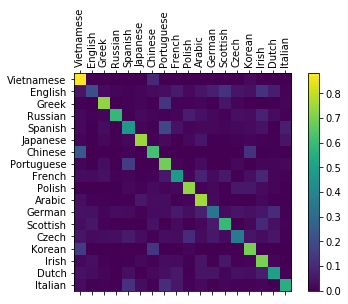

In [162]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    start_time = time.time()

    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    print("--- %s seconds ---" % (time.time() - start_time))
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [163]:

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
#         print(output)
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
--- 0.0013060569763183594 seconds ---
(-0.71) Russian
(-0.98) Czech
(-2.98) English

> Jackson
--- 0.0005233287811279297 seconds ---
(-0.77) Scottish
(-1.81) English
(-2.04) Russian

> Satoshi
--- 0.0004475116729736328 seconds ---
(-0.96) Japanese
(-1.07) Arabic
(-2.47) Italian


# Exporting the model to onnx and caffe with speed comparison

In [29]:
torch_out = torch.onnx.export(rnn, (lineToTensor('akansha')[0], rnn.initHidden()), 'char_rnn.onnx', export_params=True, verbose=True) # produces the RuntimeError below

graph(%0 : Float(1, 57)
      %1 : Float(1, 128)
      %2 : Float(128, 185)
      %3 : Float(128)
      %4 : Float(18, 185)
      %5 : Float(18)) {
  %6 : Float(1, 185) = onnx::Concat[axis=1](%0, %1), scope: RNN
  %7 : Float(1, 128) = onnx::Gemm[alpha=1, beta=1, transB=1](%6, %2, %3), scope: RNN/Linear[i2h]
  %8 : Float(1, 18) = onnx::Gemm[alpha=1, beta=1, transB=1](%6, %4, %5), scope: RNN/Linear[i2o]
  %9 : Float(1, 18) = onnx::LogSoftmax[axis=1](%8), scope: RNN/LogSoftmax[softmax]
  return (%9, %7);
}



In [105]:
import onnx
import caffe2
import caffe2.python.onnx.backend as onnx_caffe2_backend

# Load the ONNX ModelProto object. model is a standard Python protobuf object

model = onnx.load("char_rnn.onnx")


In [198]:
# takes array input instead of torch tensor
input1 = lineToTensor('akansha')[0].data.numpy()
input2 = rnn.initHidden().data.numpy()

In [184]:

start_time = time.time()

outputs, h = caffe2.python.onnx.backend.run_model(model, [input1, input2])

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0037317276000976562 seconds ---


In [197]:
outputs  # produces array output instead of torch tensor

array([[-2.9767115, -3.9674525, -4.4818587, -4.1358232, -1.5902249,
        -2.1790602, -3.5392349, -2.0714395, -4.532489 , -3.098593 ,
        -2.8341017, -4.095789 , -4.392009 , -1.9894357, -2.8543322,
        -3.8520563, -4.1054077, -2.900301 ]], dtype=float32)

### time taken for rnn run for torch and onnx model

In [199]:
start_time = time.time()

torch_output, h = rnn(lineToTensor('akansha')[0], rnn.initHidden())

print("--- %s seconds ---" % (time.time() - start_time))


--- 0.0018939971923828125 seconds ---


In [200]:

start_time = time.time()

caffe_outputs, h = caffe2.python.onnx.backend.run_model(model, [lineToTensor('akansha')[0].data.numpy(), rnn.initHidden().data.numpy()])

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.004292726516723633 seconds ---


## evaluating on caffe model

In [201]:
def evaluateCaffe2Model(line_tensor):
    start_time = time.time()
    
    hidden = rnn.initHidden()
    input2 = hidden.data.numpy()

    for i in range(line_tensor.size()[0]):
#         print(line_tensor[i])
        input1 = line_tensor[i].data.numpy()
#         print(hidden)
#         print(input1)
#         print(len(input1))
#         print(len(input2))
#         print(input2)
        output, hidden = caffe2.python.onnx.backend.run_model(model, [input1, input2])
#         print("%")
    print("--- %s seconds ---" % (time.time() - start_time))
    return output

In [202]:
output = evaluateCaffe2Model(lineToTensor('Dovesky'))
output = torch.from_numpy(output)

--- 0.02412557601928711 seconds ---


In [203]:
output

tensor([[-2.6946, -1.6879, -4.6592, -2.7151, -4.0047, -4.0378, -3.4101, -4.2404,
         -2.7819, -3.8321, -3.0056, -3.5826, -2.1103, -2.7538, -2.7331, -1.9810,
         -3.7222, -4.1588]])

In [204]:
topv, topi = output.topk(3, 1, True)
predictions = []

for i in range(3):
    value = topv[0][i].item()
    category_index = topi[0][i].item()
    print('(%.2f) %s' % (value, all_categories[category_index]))
    predictions.append([value, all_categories[category_index]])


(-1.69) English
(-1.98) Irish
(-2.11) Scottish


In [205]:
def predictCaffe2Model(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluateCaffe2Model(lineToTensor(input_line))
        output = torch.from_numpy(output)
#         print(output)
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predictCaffe2Model('Dovesky')
predictCaffe2Model('Jackson')
predictCaffe2Model('Satoshi')


> Dovesky
--- 0.023533344268798828 seconds ---
(-1.69) English
(-1.98) Irish
(-2.11) Scottish

> Jackson
--- 0.02212238311767578 seconds ---
(-1.54) Irish
(-2.11) English
(-2.14) Dutch

> Satoshi
--- 0.022337913513183594 seconds ---
(-0.92) Italian
(-1.96) Japanese
(-2.58) Korean


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


